In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False

In [2]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-03-23 19:00:00,597 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:b1:6a:38:3C
2023-03-23 19:00:04,350 | INFO     |: Connected to C0:83:b1:6a:38:3C


D:\Workspace\ECE-5160-Sp23\ble_robot-1.1\ble_python\base_ble.py:87: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [3]:
def get_data_cb(uuid, byte_array):
    global tof_list, pwm_list
    if byte_array is not None:
        s = byte_array.decode("utf-8")
        s = s.split("|")  # split each reading
        
        if s[0] == 'T':
            # TOF
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                tof  = int(data[1])
                if tof > 0:
                    tof_time_list.append(time)
                    tof_data_list.append(tof)
        else:
            # PWM
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                pwm  = int(data[1])
                if pwm > 0:
                    pwm_time_list.append(time)
                    pwm_data_list.append(pwm)

In [4]:
ble.start_notify(ble.uuid['RX_STRING'], get_data_cb)

In [5]:
tof_data_list = []
pwm_data_list = []
tof_time_list = []
pwm_time_list = []


In [6]:
# start
ble.send_command(CMD.SEND_TWO_INTS, "")

In [7]:
# stop
ble.send_command(CMD.SEND_THREE_FLOATS, "")

In [8]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [17]:
tof_time_list = [x - tof_time_list[0] for x in tof_time_list]
pwm_time_list = [x - pwm_time_list[0] for x in pwm_time_list]

if tof_time_list[-1] > 1000:
    tof_time_list = np.array(tof_time_list)/1000
    pwm_time_list = np.array(pwm_time_list)/1000

In [18]:
print(tof_data_list)
print(tof_time_list)
print(pwm_data_list)
print(pwm_time_list)

[2019, 2011, 2008, 2001, 1968, 1934, 1881, 1846, 1799, 1742, 1672, 1612, 1506, 1415, 1304, 1218, 1122, 1025, 926, 821, 716, 612, 520, 449, 391, 344, 306, 283, 269, 262, 264, 265, 267, 268, 272, 275, 280, 286, 292]
[0.    0.065 0.136 0.205 0.267 0.331 0.396 0.462 0.526 0.588 0.651 0.715
 0.781 0.848 0.911 0.975 1.037 1.102 1.166 1.232 1.301 1.378 1.446 1.51
 1.576 1.641 1.71  1.774 1.84  1.905 1.971 2.037 2.113 2.179 2.249 2.317
 2.381 2.447 2.508]
[0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.    0.065 0.136 0.205 0.267 0.331 0.396 0.462 0.526 0.588 0.651 0.715
 0.781 0.848 0.911 0.975 1.037 1.102 1.166 1.232 1.301 1.378 1.446 1.51
 1.576 1.641 1.71  1.774 1.84  1.905 1.971 2.037 2.113 2.179 2.249 2.317
 2.381 2.447 2.508]


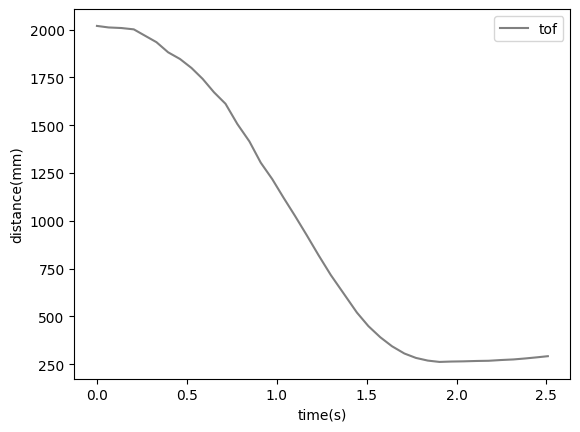

In [20]:
plt.plot(tof_time_list, tof_data_list, color='gray', label='tof')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.show()

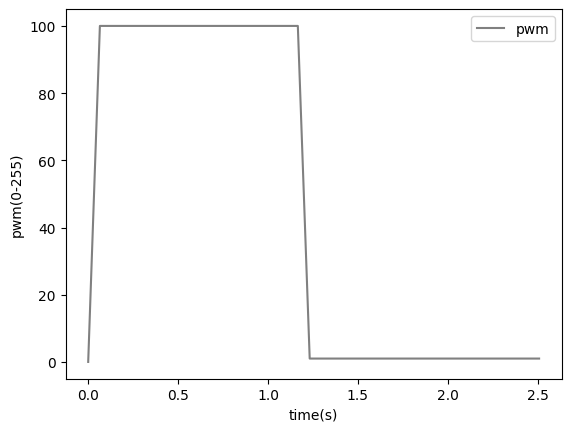

In [25]:
if pwm_data_list[0] != 0:
    pwm_data_list[0] = 0

plt.plot(pwm_time_list, pwm_data_list, color='gray', label='pwm')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('pwm(0-255)')
plt.show()

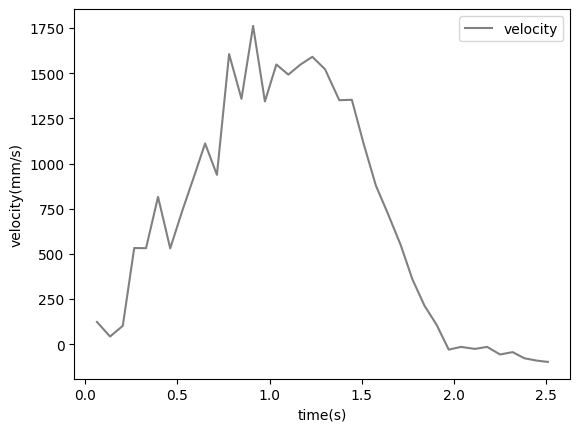

In [42]:
velocity_list = -1 * np.diff(tof_data_list)/np.diff(tof_time_list)
plt.plot(tof_time_list[1:], velocity_list, color='gray', label='velocity')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('velocity(mm/s)')
plt.show()

In [54]:
max_vel = max(velocity_list)
rise_val = max_vel * 0.9
rise_time = tof_time_list[ np.where(velocity_list > rise_val)[0][0] + 1]
drag = 1/max_vel

print("90% rise time =", rise_time, "s")
print("Max velocity = {v:.2f}".format(v=max_vel), "mm/s")
print("Drag = {d:.6f}".format(d=drag))

90% rise time = 0.781 s
Max velocity = 1761.90 mm/s
Drag = 0.000568
